In [41]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [42]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

In [45]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [46]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.226
Iter 2/50 - Loss: 1.186
Iter 3/50 - Loss: 1.144
Iter 4/50 - Loss: 1.102
Iter 5/50 - Loss: 1.059
Iter 6/50 - Loss: 1.017
Iter 7/50 - Loss: 0.975
Iter 8/50 - Loss: 0.933
Iter 9/50 - Loss: 0.891
Iter 10/50 - Loss: 0.849
Iter 11/50 - Loss: 0.809
Iter 12/50 - Loss: 0.770
Iter 13/50 - Loss: 0.730
Iter 14/50 - Loss: 0.691
Iter 15/50 - Loss: 0.652
Iter 16/50 - Loss: 0.611
Iter 17/50 - Loss: 0.571
Iter 18/50 - Loss: 0.529
Iter 19/50 - Loss: 0.488
Iter 20/50 - Loss: 0.446
Iter 21/50 - Loss: 0.404
Iter 22/50 - Loss: 0.363
Iter 23/50 - Loss: 0.323
Iter 24/50 - Loss: 0.284
Iter 25/50 - Loss: 0.246
Iter 26/50 - Loss: 0.209
Iter 27/50 - Loss: 0.174
Iter 28/50 - Loss: 0.140
Iter 29/50 - Loss: 0.108
Iter 30/50 - Loss: 0.077
Iter 31/50 - Loss: 0.047
Iter 32/50 - Loss: 0.019
Iter 33/50 - Loss: -0.006
Iter 34/50 - Loss: -0.029
Iter 35/50 - Loss: -0.050
Iter 36/50 - Loss: -0.068
Iter 37/50 - Loss: -0.083
Iter 38/50 - Loss: -0.096
Iter 39/50 - Loss: -0.107
Iter 40/50 - Loss: -0.115
I

Text(0.5, 1.0, 'Observed Values (Likelihood)')

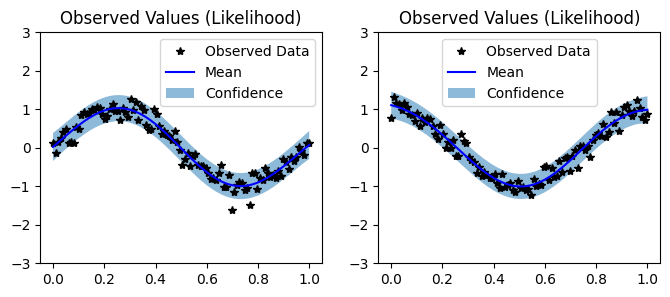

In [47]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')
